In [1]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping


2024-08-03 09:21:40.761101: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 09:21:40.761238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 09:21:40.870096: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from keras.utils import to_categorical

In [3]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [4]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [5]:
image_size = (128, 128)
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() /255.0

In [6]:
X = [] # ELA converted images
Y = [] #

In [7]:
import random
path = '/kaggle/input/casia-dataset/CASIA2/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')
                
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
7354 7354


In [8]:
path = '/kaggle/input/casia-dataset/CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 7500 images
Processing 8000 images
Processing 8500 images
Processing 9000 images
Processing 9500 images
Processing 10000 images
Processing 10500 images
Processing 11000 images
Processing 11500 images
Processing 12000 images
12477 12477


In [9]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

9981 9981
2496 2496


In [11]:
def build_model():
    model = keras.Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [12]:
model = build_model()
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 120, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,520,034 (112.61 MB)

 Trainable params: 29,520,034 (112.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
epochs = 35
batch_size = 32

In [14]:
init_lr = 1e-4
optimizer = Adam(learning_rate = init_lr, decay = init_lr/epochs )

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [15]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [16]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0.05,
                              patience = 20,
                              verbose = 0,
                              mode = 'max')

In [17]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/35
  3/312 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4653 - loss: 0.6872 

I0000 00:00:1722677126.360780      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722677126.382448      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7403 - loss: 0.4774

W0000 00:00:1722677145.685292      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


312/312 ━━━━━━━━━━━━━━━━━━━━ 31s 64ms/step - accuracy: 0.7406 - loss: 0.4771 - val_accuracy: 0.8678 - val_loss: 0.3449
Epoch 2/35
  5/312 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.8995 - loss: 0.3098

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


312/312 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8841 - loss: 0.3217 - val_accuracy: 0.8634 - val_loss: 0.3339
Epoch 3/35
312/312 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8886 - loss: 0.3004 - val_accuracy: 0.8806 - val_loss: 0.2987
Epoch 4/35
312/312 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8941 - loss: 0.2845 - val_accuracy: 0.8790 - val_loss: 0.3020
Epoch 5/35
312/312 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9043 - loss: 0.2481 - val_accuracy: 0.8870 - val_loss: 0.2679
Epoch 6/35
312/312 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9056 - loss: 0.2340 - val_accuracy: 0.8778 - val_loss: 0.2837
Epoch 7/35
312/312 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9081 - loss: 0.2179 - val_accuracy: 0.8854 - val_loss: 0.2720
Epoch 8/35
312/312 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9196 - loss: 0.1961 - val_accuracy: 0.8962 - val_loss: 0.2373
Epoch 9/35
312/312 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9164 - loss: 0.2010 - val_accurac

In [18]:
model.save('/kaggle/working/model_casia_run1.h5')

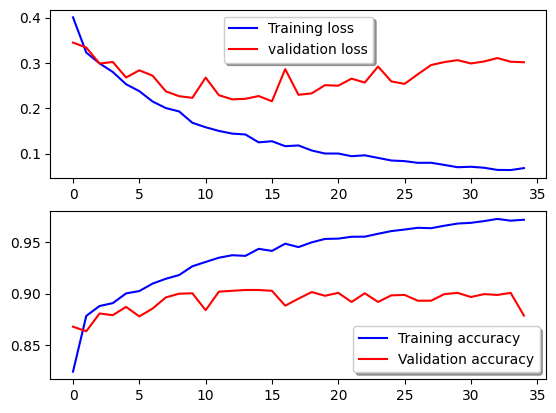

In [19]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

19/78 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

W0000 00:00:1722677534.184947      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


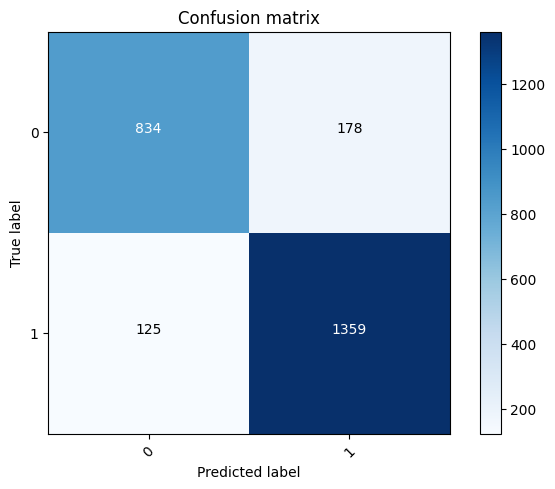

In [21]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [22]:
class_names = ['fake', 'real']

In [23]:
real_image_path = '/kaggle/input/casia-dataset/CASIA1/Sp/Sp_D_NND_A_sec0067_ani0096_0620.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
Class: fake Confidence: 100.00


In [24]:
fake_image_path = '/kaggle/input/casia-dataset/casia/CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'
image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class: fake Confidence: 99.95


In [25]:
fake_image = os.listdir('/kaggle/input/fake-images')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or file_name.endswith('tif'):
        fake_image_path = os.path.join('/kaggle/input/fake-images', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1
        print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class: real Confidence: 99.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class: real Confidence: 99.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class: real Confidence: 99.93
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class: real Confidence: 99.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class: real Confidence: 99.93
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class: real Confidence: 99.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class: real Confidence: 99.98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class: real Confidence: 99.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class: real Confidence: 100.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Class: real Confidence: 100.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class: real Confidence: 99.90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class: real Confidence: 100.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class: real Confidence: 100.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class: real Confidence: 99.92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class:

In [26]:
fake_image = os.listdir('/kaggle/input/casia-dataset/casia/CASIA2/Tp/')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or file_name.endswith('tif'):
        fake_image_path = os.path.join('/kaggle/input/casia-dataset/casia/CASIA2/Tp/', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1
        print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class: fake Confidence: 100.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Class: fake Confidence: 99.95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Class: fake Confidence: 99.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class: fake Confidence: 100.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class: fake Confidence: 100.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class: fake Confidence: 99.27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class: fake Confidence: 100.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class: fake Confidence: 100.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class: fake Confidence: 100.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class: fake Confidence: 100.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class: fake Confidence: 99.89
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Class: fake Confidence: 100.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class: real Confidence: 69.89
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Class: fake Confidence: 89.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Cl